# Demo for Text Conditioning

In [1]:
# Designate GPU to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [2]:
# import libraries
import numpy as np
from PIL import Image
from pathlib import Path
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils
import torch.nn.functional as F

from collections import OrderedDict
from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif
from utils.build_materials import build_materials
from utils.pormake_serialize import serialize
from sklearn.preprocessing import LabelEncoder
import joblib

from visualize.visualizer import MOFVisualizer, animate, resize_gif, make_concat_gif
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import glob
import os

import warnings
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

%load_ext autoreload
%autoreload 2

/home/inukai/miniconda3/envs/moffusion/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
>>> Console logs (under WARNING level) are disabled.
>>> Console logs (under WARNING level) are disabled.


In [3]:
# Options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import MOFFUSIONTextOpt

seed = 1
opt = MOFFUSIONTextOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] MOFFUSION-Text-Option initialized.


In [4]:
# Initialize MOFFUSION-text model
ckpt_path = 'saved_ckpt/moffusion_text.pth'
opt.init_model_args(ckpt_path=ckpt_path)
MOFFUSION = create_model(opt)
cprint(f'[*] "{MOFFUSION.name()}" loaded.', 'cyan')

[*] VQVAE: weight successfully load from: ./saved_ckpt/vqvae.pth


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[*] weight successfully load from: saved_ckpt/moffusion_text.pth
[*] setting ddim_steps=100
[*] Model has been created: MOFFUSION-Text-Model
[*] "MOFFUSION-Text-Model" loaded.


In [5]:
# Initialize Cascaded MOF Constructor
# A model for topology prediction
opt.model = opt.res_topo_model
opt.ckpt = opt.res_topo_ckpt
res_topo_model = create_model(opt)
cprint(f'[*] "{opt.model}" initialized.', 'cyan')


# A model for building blocks prediction
opt.model = opt.res_BB_model
opt.ckpt = opt.res_BB_ckpt
res_BB_model = create_model(opt)
cprint(f'[*] "{opt.model}" initialized.', 'cyan')

[*] weight successfully load from: ./saved_ckpt/mof_constructor_topo.pth
[*] Model has been created: MOF-Constructor_Topo-Model
[*] "mof_constructor_topo" initialized.
[*] weight successfully load from: ./saved_ckpt/mof_constructor_BB.pth
[*] Model has been created: MOF-Constructor_BB-Model
[*] "mof_constructor_BB" initialized.


In [6]:
# Designate input prompt, number of generation attempts, and repository to save
# If ngen is too large, it is recommended to split it into several batches 

input_prompts='with a lta topology'
ngen=20

save_dir='./samples/Demo_text'
save_dir_path = Path(save_dir)
if save_dir_path.exists():
    cprint('Caution! A folder with the same name might cause undesired situations. Please remove the old folder.', 'cyan')
save_dir_path.mkdir(exist_ok=True)

Caution! A folder with the same name might cause undesired situations. Please remove the old folder.


In [7]:
# Generation Begins!
MOFFUSION.txt2shape(ngen=ngen, input_txt=input_prompts)
gen_df = MOFFUSION.gen_df

# Save generated SDFs into repository
for i in range(len(gen_df)):
    np.save(f'{save_dir}/{i}.npy', gen_df[i].detach().cpu())

cprint(f'[*] SDF Generated', 'cyan')

Data shape for DDIM sampling is (20, 3, 8, 8, 8), eta 0.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.29it/s]


[*] SDF Generated


Warning! At most 6 meshes will be shown


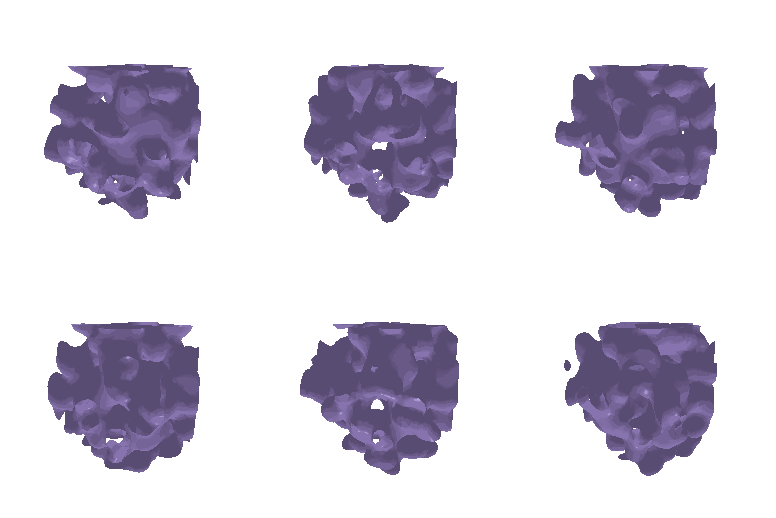

[*] Generated SDFs visualized.


In [8]:
# Visualize generated SDFs
# If num_sample is large, only 6 will be displayed and warning will be shown. (Can be modified in utils/util_3d.py)
mesh_shape_comp = sdf_to_mesh(gen_df, demo=True, color=(0.7, 0.6, 0.9))

sc_output_name = f'{save_dir}/generated_sdf.gif'
save_mesh_as_gif(MOFFUSION.renderer, mesh_shape_comp, nrow=3, out_name=sc_output_name)

display(ipy_image(sc_output_name))
cprint(f'[*] Generated SDFs visualized.', 'cyan')

In [9]:
# Obtain MOFs using MOF Constructor

# initialize Enocders for topology/node/edge
topo_encoder = opt.encoders['topo'] 
node_encoder = opt.encoders['node'] 
edge_encoder = opt.encoders['edge'] 


# 1. Cascaded MOF Constructor (Topology)
topo_pred = res_topo_model.predict(gen_df)
cprint(f'[*] Topology Predicted', 'cyan')


# 2. Cascaded MOF Constructor (Building Blocks)
mof_pred = res_BB_model.predict(gen_df, topo_pred)
cprint(f'[*] Building Blocks Predicted', 'cyan')


# Save result as text file
with open (f'{save_dir}/MOF_Constructor_output.txt', 'a') as f:
    for mof in mof_pred:
        topos = topo_encoder.inverse_transform(mof[0].tolist())
        nodes_1 = node_encoder.inverse_transform(mof[1].tolist())
        nodes_2 = node_encoder.inverse_transform(mof[2].tolist())       
        edges = edge_encoder.inverse_transform(mof[3].tolist())    

        if nodes_2 == 'N0':
            f.write(topos[0]+'+'+nodes_1[0]+'+'+edges[0]+'\n')
        else:
            f.write(topos[0]+'+'+nodes_1[0]+'+'+nodes_2[0]+'+'+edges[0]+'\n') 

cprint(f'[*] Result saved in {save_dir}/MOF_Constructor_output.txt', 'cyan')

[*] Topology Predicted
[*] Building Blocks Predicted
[*] Result saved in ./samples/Demo_text/MOF_Constructor_output.txt


In [10]:
# Generate MOF structures using PORMAKE

# For convenience, generated structures are divided as follows:
# mof_gen_success : generated MOFs with cell length smaller than 60 Å
# mof_gen_large : generated MOFs with cell length larger than 60 Å

# Prepare repositories to store
mof_gen_success = f'{save_dir}/mof_success'
mof_gen_large = f'{save_dir}/mof_large_cell'

success_dir = Path(mof_gen_success)
success_dir.mkdir(exist_ok=True)

fail_dir = Path(mof_gen_large)
fail_dir.mkdir(exist_ok=True)

# Start generation
try:
    build_materials(candidate_file = f'{save_dir}/MOF_Constructor_output.txt', save_dir = mof_gen_success, large_dir = mof_gen_large)
except FileNotFoundError:
    pass
cprint(f'[*] MOFs Generated in {save_dir}/mof_success', 'cyan')

Start generation.
lta+N671+E132 

Success (small).
lta+N671+E149 Success (small).
lta+N691+E127 Success (small).
lta+N482+E146 Success (small).
lta+N599+E50 Success (small).
lta+N599+E201 Success (small).
lta+N599+E63 Success (small).
lta+N650+E51 Success (small).
lta+N691+E127 Success (small).
lta+N599+E63 Success (small).
lta+N671+E162 Success (small).
lta+N446+E228 Success (small).
lta+N650+E51 Success (small).
lta+N446+E120 Success (small).
lta+N599+E201 Success (small).
lta+N599+E63 Success (small).
lta+N599+E127 Success (small).
lta+N671+E201 Success (small).
lta+N599+E63 Success (small).
lta+N242+E153 Success (small).
lta+N671+E132 Success (small).
lta+N671+E149 Success (small).
lta+N691+E127 Success (small).
lta+N482+E146 Success (small).
lta+N599+E50 Success (small).
lta+N599+E201 Success (small).
lta+N599+E63 Success (small).
lta+N650+E51 Success (small).
lta+N691+E127 Success (small).
lta+N599+E63 Success (small).
lta+N671+E162 Success (small).
lta+N446+E228 Success (small).
lta+N650+E51 Success (small).
lta

In [ ]:
## This process might take 2~3 minutes
# Generate .gif of MOFs and visualize 
# Repository that gifs will be stored

mof_gif_dir = f'{save_dir}/mof_success_gif'

gif_dir = Path(mof_gif_dir)
gif_dir.mkdir(exist_ok=True)

# Generate gifs
make_concat_gif(cif_dir = mof_gen_success, gif_dir = mof_gif_dir)
display(ipy_image(f'{mof_gif_dir}/mof_concat.gif'))
cprint('Please note that these structures have yet to be optimized', 'cyan')

In [ ]:
# Cells to add to the end of the notebook
import gc
import torch

# Remove global variables (if necessary)
for name in dir():
    if not name.startswith('_') and name not in ['gc', 'torch']:
        del globals()[name]

# Garbage collection and CUDA memory release
gc.collect()
torch.cuda.empty_cache()

print("Memory has been released.")